In [1]:
from gpseer.statistics import fit_peaks, pearson

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from gpseer.predictor import Predictor
from seqspace.gpm import GenotypePhenotypeMap
from epistasis.models import LinearEpistasisRegression
from gpseer.statistics import lorentz, gaussian

In [3]:
space = GenotypePhenotypeMap.from_json("linear.json")
predictor = Predictor(space, LinearEpistasisRegression, order=4)

In [4]:
predictor.sample_to_convergence("AAAA", rtol=1e-2)
#predictor.sample_to_convergence("AVVA", rtol=1e-2)
#predictor.sample_to_convergence("AVAA", rtol=1e-2)
#predictor.sample_to_convergence("AVAV", rtol=1e-2)
#predictor.sample_to_convergence("VVVV", rtol=1e-2)


/Users/Zsailer/virtual/py3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/Zsailer/virtual/py3/lib/python3.5/site-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [5]:
t = predictor.genotypes.gAVVA.fit_peaks()
t2 = predictor.genotypes.gAVAA.fit_peaks()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

In [6]:
t2

NameError: name 't2' is not defined

In [7]:
d1 = predictor.genotypes.gAVVA.samples()
d2 = predictor.genotypes.gAVAA.samples()
d4 = predictor.genotypes.gVVAA.samples()

d3 = np.concatenate((d1, d2, d4))
f = np.histogram(d3, bins=70, normed=True)

<Container object of 70 artists>

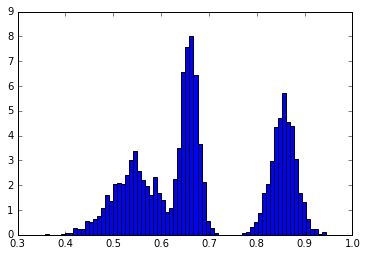

In [8]:
plt.bar(f[1][1:], f[0], width=f[1][2] - f[1][1])

In [76]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks_cwt

def pearson(y_obs, y_pred):
    """ Calculate pearson coefficient between two variables.
    """
    x = y_obs
    y = y_pred

    xbar = np.mean(y_obs)
    ybar = np.mean(y_pred)

    terms = np.zeros(len(x), dtype=float)

    for i in range(len(x)):
        terms[i] = (x[i] - xbar) * (y[i] - ybar)

    numerator = sum(terms)

    # calculate denominator
    xdenom = sum((x - xbar)**2)
    ydenom = sum((y - ybar)**2)
    denominator = np.sqrt(xdenom)*np.sqrt(ydenom)

    return numerator/denominator

def lorentz(x, center, width):
    """A Lorentz distribution for fitting peaks.

    Parameters
    ----------
    x : numpy.array
        x values for distribution
    center : float
        the center of the distribution
    width : float
        full width at half maximum.

    Returns
    -------
    distribution : numpy array
        normalized gaussian distribution
    """
    distribution = (1 / np.pi) * (0.5 * width) / ((x - center)**2 + (0.5*width)**2)
    return distribution

def gaussian(x, amp, center, width):
    """A Gaussian distribution for fitting peaks.

    Parameters
    ----------
    x : numpy.array
        x values for distribution
    center : float
        the center of the distribution
    width : float
        full width at half maximum.

    Returns
    -------
    distribution : numpy array
        normalized lorentzian distribution
    """
    distribution = amp * np.exp(-(x - center)**2/ (2*width**2))
    return distribution

def multigaussian(x, *args):
    """Construct the sum of multiple distributions.

    Parameters
    ----------
    x : numpy.array
        x values for distribution
    args :
        first half must be the center of peaks, second half are widths.
    """
    args = np.array(args)
    if len(args)%3 != 0:
        raise Exception("""Number of args must be divisible by 3.""")
    npeaks = int(len(args) / 3)
    distribution = np.zeros(len(x))
    for i in range(0, len(args), 3):
        amp = args[i]
        center = args[i+1]
        widths = args[i+2]
        distribution += gaussian(x, amp, center, widths)
    return distribution


def fit_peaks(xdata, ydata, widths=np.arange(1,100)):
    """Find peaks in a dataset using continuous wave transform and fit with
    distribution function.

    Parameters
    ----------
    xdata : array
        1-D data to search for peaks
    ydata : array
        1-D data, height of peaks
    widths :
        1-D array of widths to use for calculating the CWT matrix. In general,
        this range should cover the expected width of peaks of interest.

    Returns
    -------
    peaks : array
        list of parameters
    """
    # Find peaks using continuous wave tranform
    indices = find_peaks_cwt(ydata, widths=widths)
    npeaks = len(indices)
    # Attempt to fit npeaks with model
    attempts = 0
    score=0
    finished = False
    while attempts < 5 and finished is False and score < 0.9:
        finished = False
        # Attempt guesses that are multiple orders of magnitude
        try:
            # Construct parameters for model with guesses
            p0 = np.ones(npeaks*3) * 0.001 * 10**attempts
            for i in range(npeaks):
                p0[3*i] = ydata[indices[i]]
                p0[3*i+1] = xdata[indices[i]]
            # Fit the data with multiple peaks
            popt, pcov = curve_fit(multigaussian, xdata, ydata, p0=p0)

            if pearson(ydata, multigaussian(xdata, *popt)) < 0.9:
                finished = False
                attempts+=1
        except RuntimeError:
            attempts += 1
            print(attempts)
            


    # If the last loop didn't finish, raise an error
    if finished is False:
        raise RuntimeError("""Optimal parameters not found.""")
    # Return parameters
    peaks = []
    for i in range(0,len(popt),3):
        peaks.append((popt[i], popt[i+1], popt[i+2]))
    return peaks


In [77]:
peak1 = fit_peaks(f[1][:-1], f[0], widths=np.arange(1,20))

/Users/Zsailer/virtual/py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:601: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


KeyboardInterrupt: 

In [ ]:
peak1

0.46372825083720437

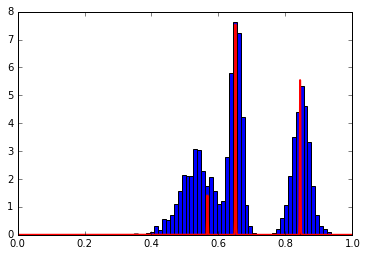

In [61]:
plt.hist(d3, bins=50, normed=True)
x = np.linspace(0,1.0, 1000)

plt.plot(x, multigaussian(x, *[i for p in peak1 for i in p]), color="r",linewidth=2)

y1 = multigaussian(f[1][:-1], *[i for p in peak1 for i in p])
y2 = f[0]
pearson(y1,y2)

<Container object of 30 artists>

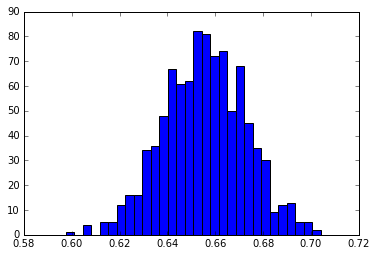

In [27]:
data  = predictor.genotypes.gAVVA.histogram()
plt.bar(data[1][1:], data[0], width=data[1][2] - data[1][1])
#plt.axis([0,1, 0, 420])